In [14]:
import pandas as pd
import numpy as np
import time
import torchvision
from torchvision import models
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from PIL import Image, ImageFile
from torch.utils.data import Dataset
import torch
import torch.optim as optim
from torchvision import transforms
from torch.optim import lr_scheduler
import os
import random
import cv2
import copy
import matplotlib.pyplot as plt
%matplotlib inline
from imgaug import augmenters as iaa



print(os.listdir("input"))

['.~lock.train.csv#', 'test.csv', 'sample_submission.csv', 'train_images.zip', 'test_images.zip', 'train.csv', 'test_images', 'train_images']


In [15]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [16]:
num_classes = 1
seed_everything(24)
lr          = 1e-3
IMG_SIZE    = 256

In [17]:
train      = 'input/train_images/'
test       = 'input/test_images/'
train_csv  = pd.read_csv('input/train.csv')

In [18]:
train_df, val_df = train_test_split(train_csv, test_size=0.1, random_state=98)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
train_df.head()

id_code  diagnosis
0  a2ddabee14e9          4
1  5cf9127f251a          2
2  2a099b247b10          2
3  3d2ecffe0386          0
4  7ce671f952be          0

In [19]:
class MyDataset(Dataset):

    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = os.path.join('input/train_images', self.df.loc[idx, 'id_code'] + '.png')
        image = simple_preprocessing(path,sigmaX=30)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image = transforms.ToPILImage()(image)

        if self.transform:
            image = self.transform(image)
        
        label = torch.tensor(self.df.loc[idx, 'diagnosis'])
        label = np.expand_dims(label, -1)  
        
        return image, label

In [89]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def circle_crop(img, sigmaX=10):   
    """
    Create circular crop around image centre    
    """    
    
    img = cv2.imread(img)
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

def circle_crop_v2(img, sigmaX=10):
    """
    Create circular crop around image centre
    """
    img = cv2.imread(img)
    img = crop_image_from_gray(img)

    height, width, depth = img.shape
    largest_side = np.max((height, width))
    img = cv2.resize(img, (largest_side, largest_side))

    height, width, depth = img.shape

    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x, y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    
    
    img=cv2.addWeighted (img, 4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    
    return img

def simple_preprocessing(img, sigmaX=10):
    img = cv2.imread(img)
    img = crop_image_from_gray(img)
#     img = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
#    img = cv2.addWeighted (img, 4, cv2.GaussianBlur( img , (0,0) , 30) ,-4 ,128)
    img = transforms.ToPILImage()(img)
    
    return img
    

def circle_crop_v3(img, sigmaX=10, green_only=True):
    """
    Create circular crop around image centre
    """
    img = cv2.imread(img)
    if green_only:
        
        img[:, :, 2] = 0
        img[:, :, 0] = 0
    else: pass
    #img = toCLAHEgreen(img)
    img = crop_image_from_gray(img)

    height, width, depth = img.shape
    largest_side = np.max((height, width))
    img = cv2.resize(img, (largest_side, largest_side))

    height, width, depth = img.shape

    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x, y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img=cv2.addWeighted (img, 4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    
    return img    

def toCLAHEgreen(img):  
    clipLimit=2.0 
    tileGridSize=(8, 8)  
    img = np.array(img)     
    green_channel = img[:, :, 1]    
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    cla = clahe.apply(green_channel) 
    cla = clahe.apply(cla)
    return cla

In [82]:
# fig, axes = plt.subplots(3,3,figsize=(10,10))
# selection = np.random.choice(train_df.index, size=9, replace=False)
# images = 'input/train_images/'+train_df.loc[selection]['id_code']+'.png'
# #image_id = 'input/train_images/'+train_df.loc[selection]['diagnosis']
# for image, axis in zip(images, axes.ravel()):
#     img = simple_preprocessing(image)
#     axis.imshow(img)

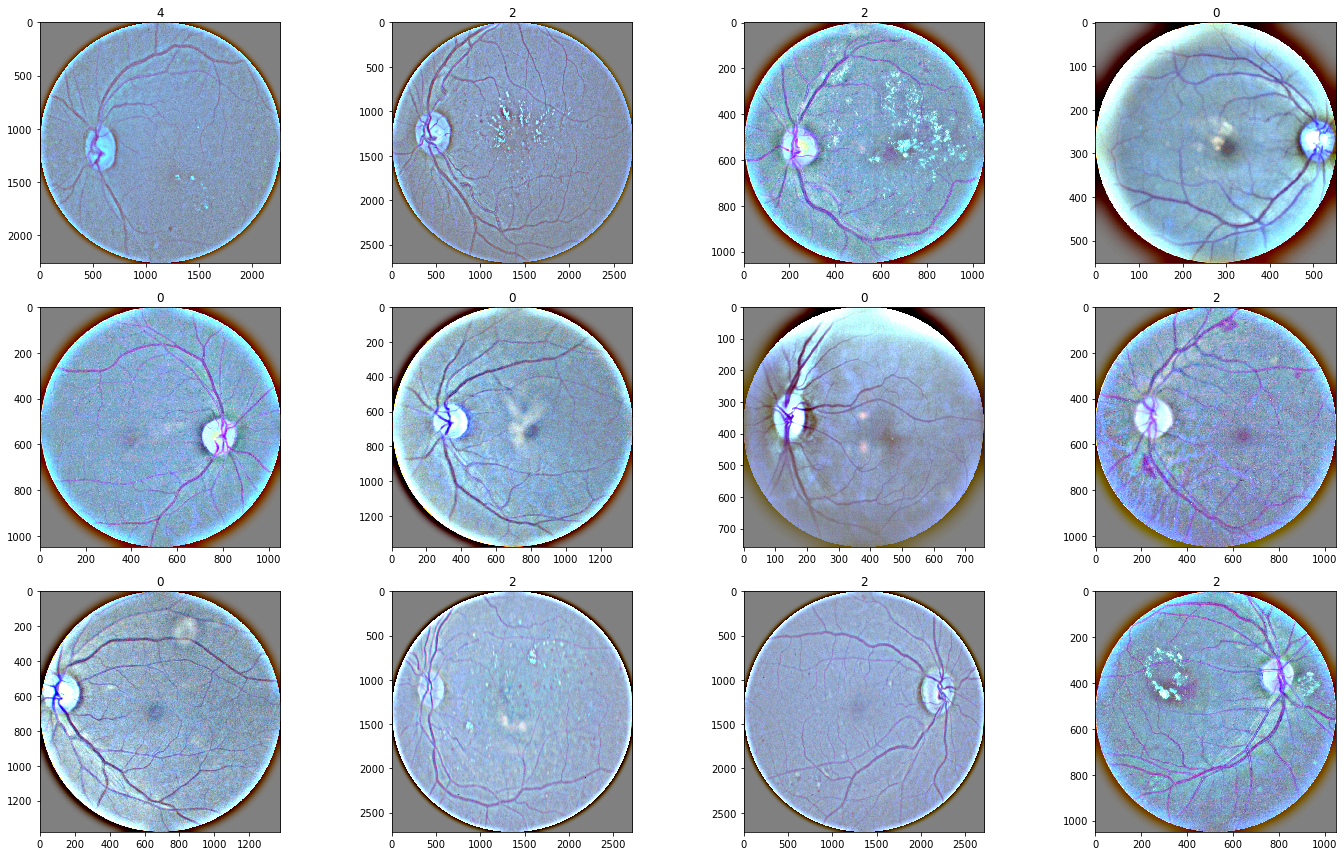

In [83]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        img = 'input/train_images/'+ df.loc[i,'id_code'] +'.png'
        image_id = df.loc[i,'diagnosis']
        img = circle_crop_v2(img, sigmaX=30)
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()
    
display_samples(train_df)

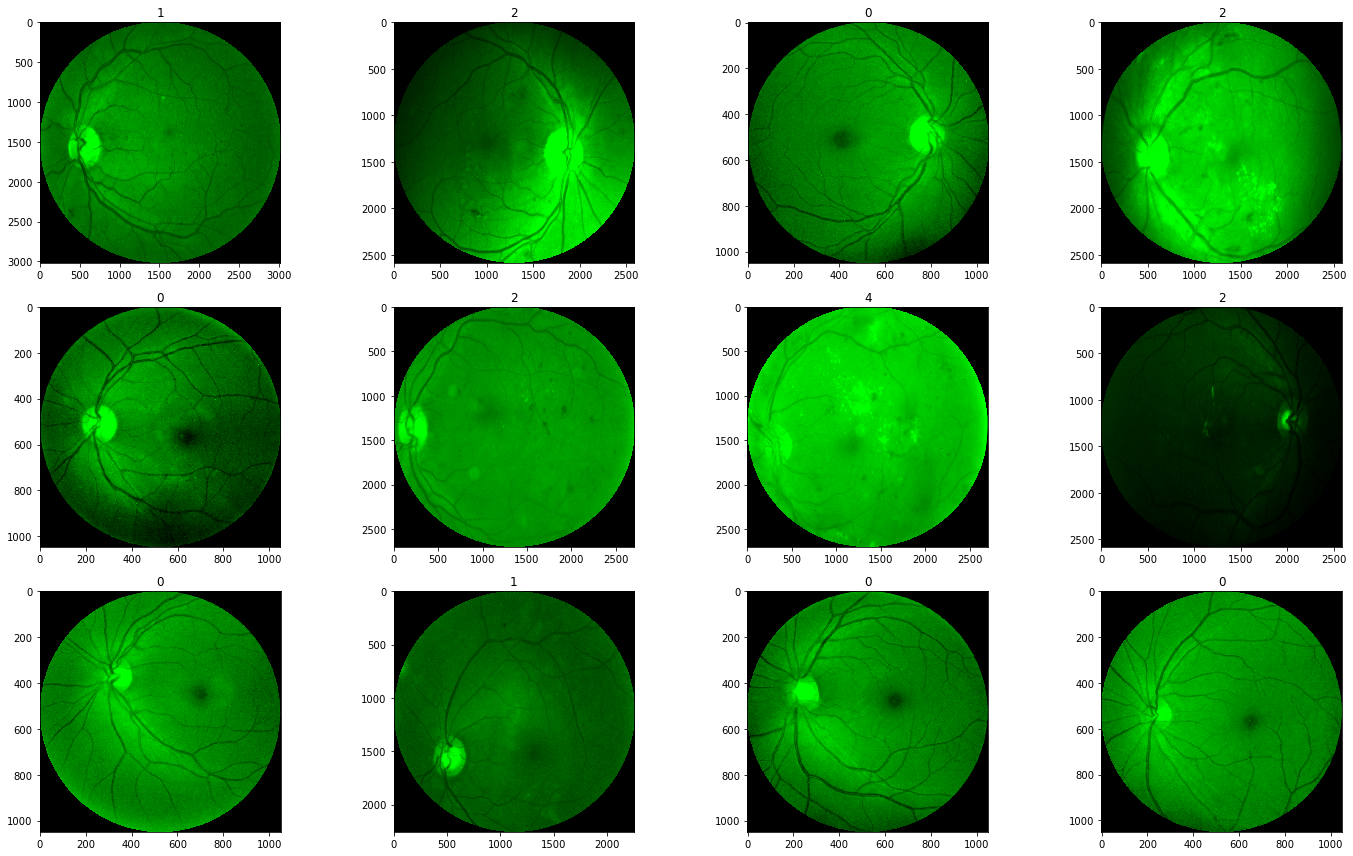

In [85]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential(
        [
            # apply the following augmenters to most images
            iaa.Fliplr(0.5), # horizontally flip 50% of all images
            iaa.Flipud(0.2), # vertically flip 20% of all images
            #iaa.Crop(percent=(0, 0.1)), # random crops
            #iaa.Grayscale(alpha=(0.5, 1.0)),
            # Change brightness of images (50-150% of original value).
            iaa.Multiply((1.5, 2.0)),

            # Improve or worsen the contrast of images.
            iaa.ContrastNormalization((1.0, 1.2)),
            #iaa.Grayscale(alpha=(0.5, 1.0)),
            # Convert each image to grayscale and then overlay the
            # result with the original with random alpha. I.e. remove
            # colors with varying strengths.
            #sometimes(iaa.Crop(percent=(0, 0.1))),

        ],
        random_order=False)

def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))
    np.random.seed(1) 
    selection = np.random.choice(df.index, size=columns*rows, replace=False)
    for ix, i in enumerate(range(columns*rows)):
        inx = selection[ix]
        image_path = df.loc[inx,'id_code']
        #print(image_path)
        img = 'input/train_images/'+ df.loc[inx,'id_code'] +'.png'
        image_id = df.loc[inx,'diagnosis']
        #img = cv2.imread(img)
        #img = toCLAHEgreen(img)
        img = circle_crop_v3(img, sigmaX=50)
        img = seq.augment_image(img)
        
        #img = toCLAHEgreen(img)
        #img = transforms.ToPILImage()(img)
        #print('---------' + str(np.mean(img)))
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

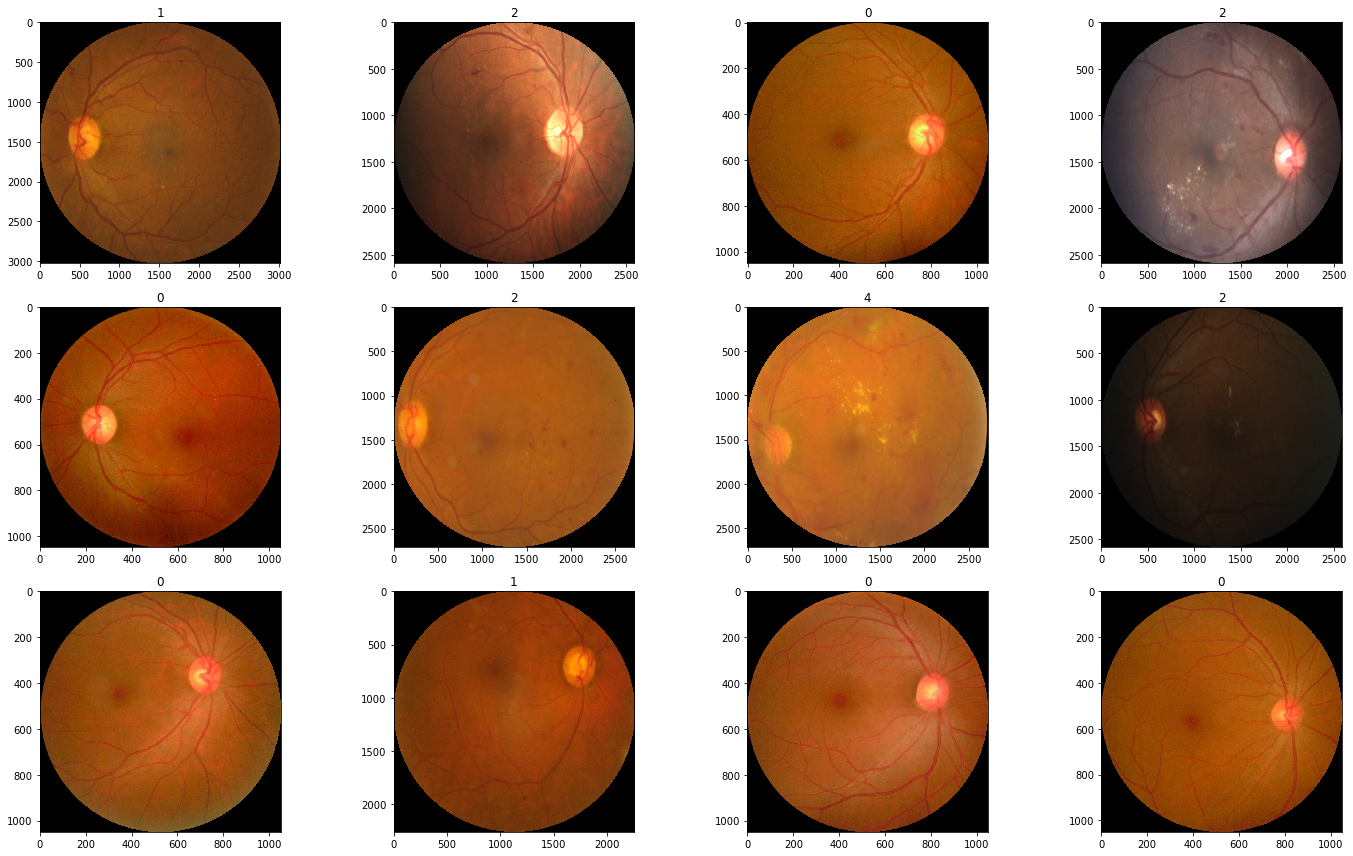

In [92]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential(
        [
            # apply the following augmenters to most images
            iaa.Fliplr(0.5), # horizontally flip 50% of all images
            iaa.Flipud(0.2), # vertically flip 20% of all images
            #iaa.Crop(percent=(0, 0.1)), # random crops
            #iaa.Grayscale(alpha=(0.5, 1.0)),
            # Change brightness of images (50-150% of original value).
            iaa.Multiply((1.5, 2.0)),

            # Improve or worsen the contrast of images.
            iaa.ContrastNormalization((1.0, 1.2)),
            iaa.Grayscale(alpha=(0.5, 1.0)),
            # Convert each image to grayscale and then overlay the
            # result with the original with random alpha. I.e. remove
            # colors with varying strengths.
            #sometimes(iaa.Crop(percent=(0, 0.1))),

        ],
        random_order=False)

def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))
    np.random.seed(1) 
    selection = np.random.choice(df.index, size=columns*rows, replace=False)
    for ix, i in enumerate(range(columns*rows)):
        inx = selection[ix]
        image_path = df.loc[inx,'id_code']
        #print(image_path)
        img = 'input/train_images/'+ df.loc[inx,'id_code'] +'.png'
        image_id = df.loc[inx,'diagnosis']
        #img = cv2.imread(img)
        #img = toCLAHEgreen(img)
        img = circle_crop_v3(img, sigmaX=30, green_only=False)
        #img = seq.augment_image(img)
#         img = toCLAHEgreen(img)
        #img = transforms.ToPILImage()(img)
        #print('---------' + str(np.mean(img)))
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

d29b37d110f3
44.50882872706977
b7a1bb106051
66.66835706727136
d144144a2f3f
37.051420212765954
fd4c946c52bf
39.41526439909297
59ee65760535
48.061914317093795
e26d8718ca58
35.57220942888695
7adfb8fc0621
71.56598760393047
47b756014447
77.97359306492304
aafe980edd0c
66.09803839758125
8d4ff745a409
78.88610430839002
27fca9f12b3c
81.73424903167313
51a1d162e223
60.84637461531838


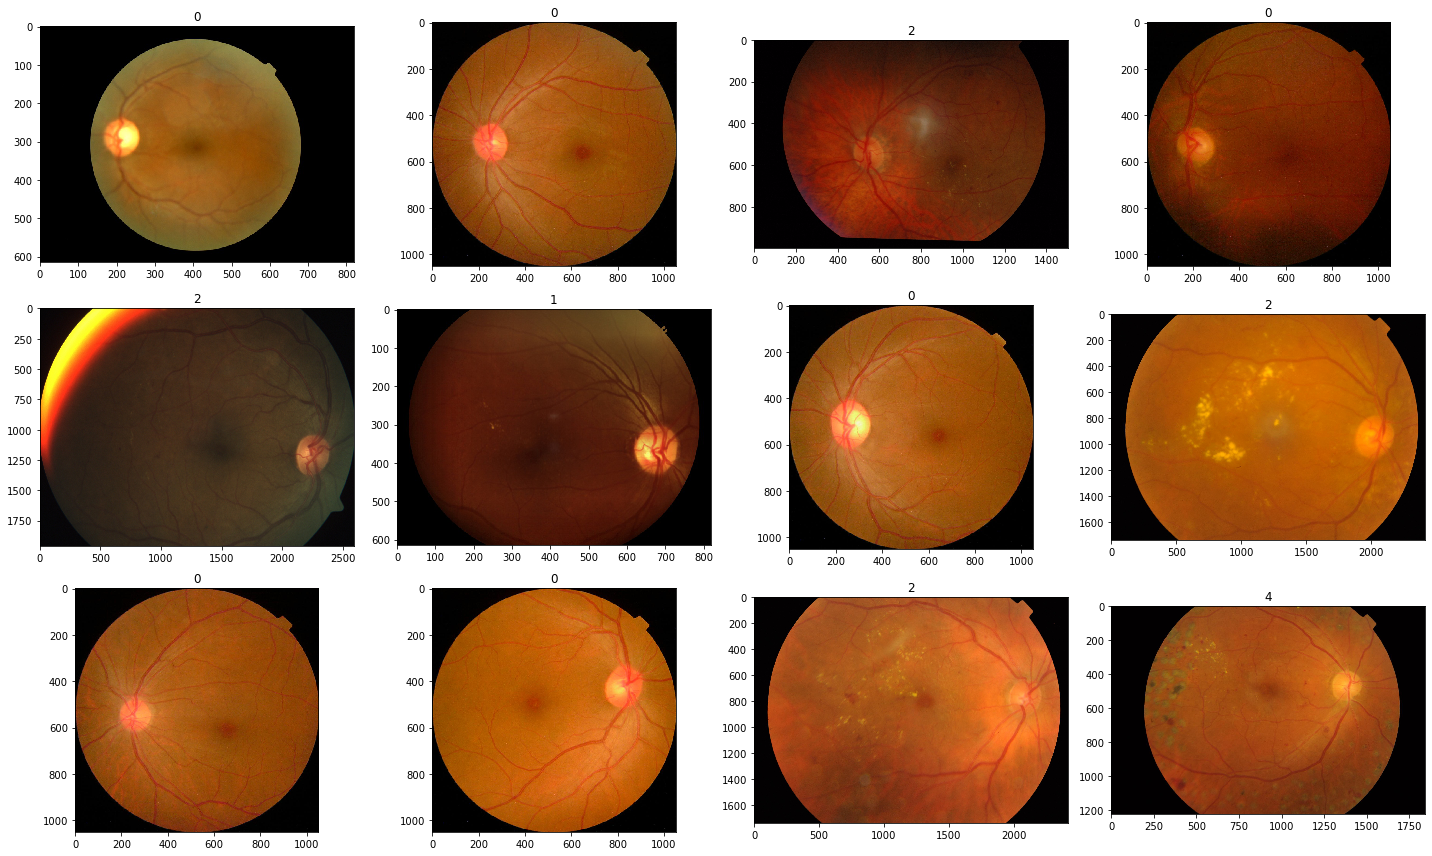

In [24]:
def img_estim(img, thrshld):
    is_light = np.mean(img) > thrshld
    return 'light' if is_light else 'dark'



def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))
    np.random.seed(59) 
    selection = np.random.choice(df.index, size=columns*rows, replace=False)
    for ix, i in enumerate(range(columns*rows)):
        inx = selection[ix]
        image_path = df.loc[inx,'id_code']
        image_id = df.loc[inx,'diagnosis']
        print(image_path)
  
        img = cv2.imread(f'input/train_images/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        print(np.mean(img))

        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()


display_samples(train_df)

In [25]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation((-120, 120)),
    transforms.ColorJitter(brightness=[1,1.5], contrast=0, saturation=0, hue=0),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

trainset     = MyDataset(train_df, transform =train_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
valset       = MyDataset(val_df, transform   =train_transform)
val_loader   = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False, num_workers=4)

In [26]:
device = torch.device("cuda:0")


In [27]:
model = models.densenet121(pretrained=True)
# model.load_state_dict(torch.load("../input/pytorch-pretrained-models/resnet101-5d3b4d8f.pth"))
num_features = model.classifier.in_features
model.classifier = nn.Linear(4096, num_classes)
model.cuda()


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/qile/.cache/torch/checkpoints/densenet121-a639ec97.pth
76.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)



In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_loader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_loader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            tk0 = tqdm(dataloader, total=int(len(dataloader)))
            # Iterate over data.
            for inputs, labels in tk0:
                inputs = inputs.to(device)
                labels = labels.float().to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
            epoch_loss = running_loss / len(dataloader)

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [13]:
model_ft = train_model(model, criterion, optimizer, scheduler,
                       num_epochs=15)

Epoch 0/14
----------



train Loss: 21.2522



val Loss: 24.7773

Epoch 1/14
----------



train Loss: 17.3365



val Loss: 14.3317

Epoch 2/14
----------



train Loss: 14.6736



val Loss: 15.0285

Epoch 3/14
----------



train Loss: 12.6068



val Loss: 15.4817

Epoch 4/14
----------



train Loss: 12.7725



val Loss: 10.5238

Epoch 5/14
----------



train Loss: 10.2208



val Loss: 9.9075

Epoch 6/14
----------



train Loss: 9.0545



val Loss: 9.8905

Epoch 7/14
----------


KeyboardInterrupt: 